In [85]:
# !pip install kaggle

In [86]:
# !pip uninstall tensorflow -y
# !pip install tensorflow-macos

In [87]:
#!pip install -q -U keras-tuner

In [88]:
# imports 
import kagglehub
import pandas as pd 
import numpy as np
import os 
from PIL import Image
import PIL.Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt 
from tensorflow.keras.models import Sequential

In [89]:
import tensorflow as tf

tf.random.set_seed(101)

### basic import and cleaning

In [90]:
# define and collect image paths and labels

# kaggle import 
path = kagglehub.dataset_download("syedalinaqvi/augmented-skin-conditions-image-dataset")
image_folder = os.path.join(path, "Skin_Conditions")
print("Image folder:", image_folder)
print("Subfolders (classes):", os.listdir(image_folder))

# create empty lists to hold image paths and labels
image_paths = []
labels = []

# iterate through each subfolder and collect image paths and labels
for label in sorted(os.listdir(image_folder)):
    label_folder = os.path.join(image_folder, label)

    if os.path.isdir(label_folder):
        for filename in os.listdir(label_folder):
            if filename.lower().endswith((".jpg", ".jpeg", ".png")):
                image_paths.append(os.path.join(label_folder, filename))
                labels.append(label)

Image folder: /Users/aidaduong/.cache/kagglehub/datasets/syedalinaqvi/augmented-skin-conditions-image-dataset/versions/1/Skin_Conditions
Subfolders (classes): ['Carcinoma', '.DS_Store', 'Keratosis', 'Acne', 'Eczema', 'Rosacea', 'Milia']


In [91]:
# create dataframe
df = pd.DataFrame({"image_path": image_paths, "labels": labels})

# remove rows w/ missing or invalid paths 
df = df[df["image_path"].apply(os.path.exists)]
df = df.drop_duplicates()

# summary (to check if it matches up w/ what kaggle says)
print(f"\nTotal images: {len(df)}")
print("Images per class:")
print(df["labels"].value_counts())


Total images: 2394
Images per class:
labels
Acne         399
Carcinoma    399
Eczema       399
Keratosis    399
Milia        399
Rosacea      399
Name: count, dtype: int64


In [92]:
print(tf.__version__)

2.16.2


### view images

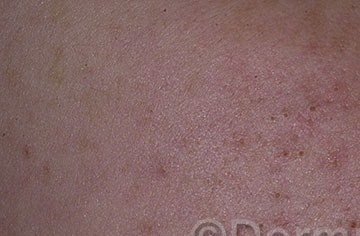

In [93]:
acne_images = df[df["labels"] == "Acne"]["image_path"].tolist()
PIL.Image.open(acne_images[3])

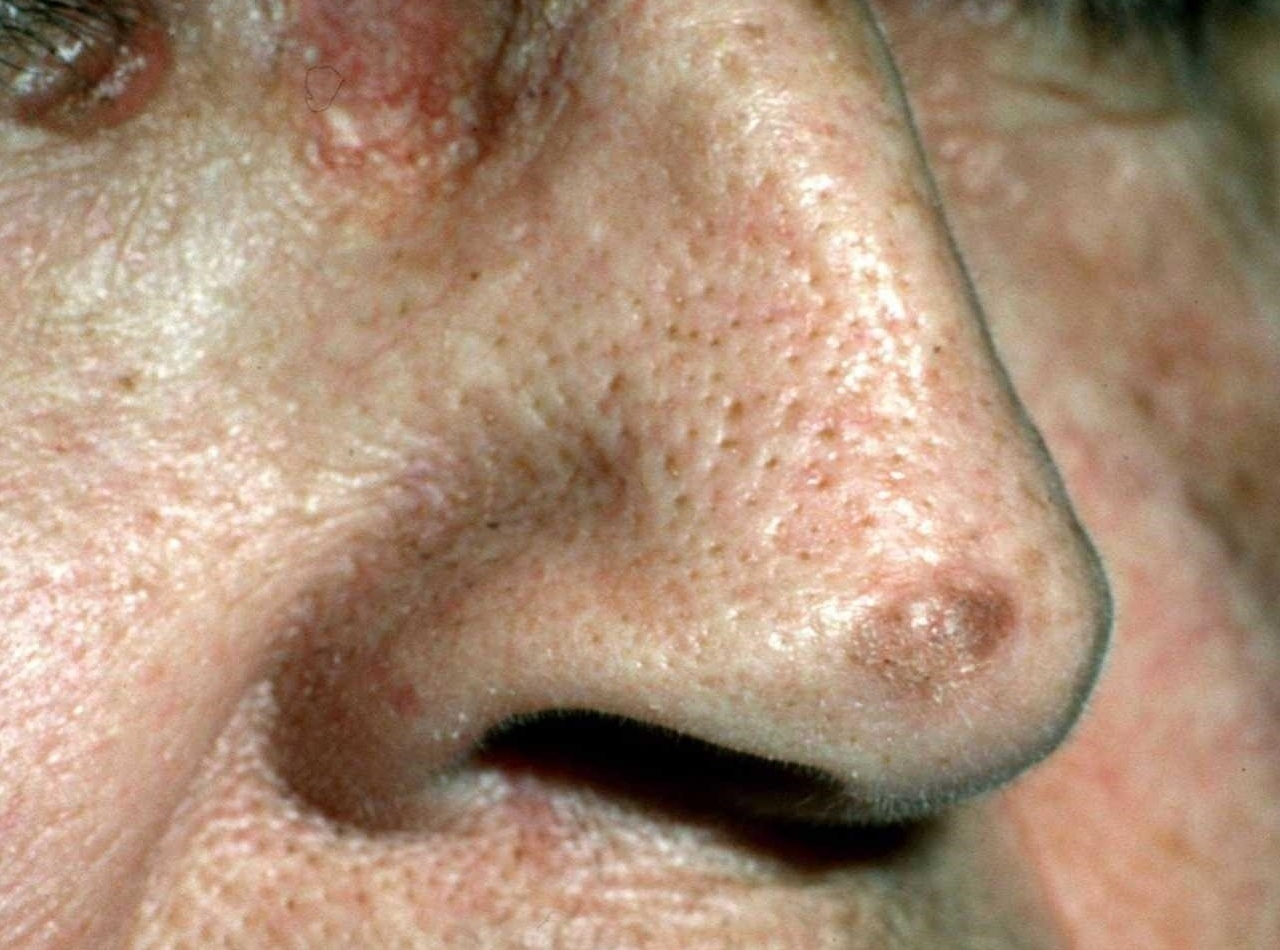

In [94]:
carcinoma_images = df[df["labels"] == "Carcinoma"]["image_path"].tolist()
PIL.Image.open(carcinoma_images[3])

## using: https://www.tensorflow.org/tutorials/load_data/images

### load data using a keras utility
these use the `tf.kera.utils.image_dataset_from directory` utility. this basically helps generate a dataset from image files in a directory. 
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

#### create a dataset
defining some parameters for the loader first.

In [95]:
batch_size = 32
img_height = 180
img_width = 180

# added this one 
# num_classes = df["labels"].nunique()

use a validation split when developing model, using the standard 80% for training and 20% for validation. the `image_folder` variable is where all the images are stored and the image sizes are set to the parameters above.

**note:** above parameters were pulled directly from tensorflow tutorial, can tune later.

In [96]:
# train model 

train_ds = tf.keras.utils.image_dataset_from_directory(
  image_folder,
  validation_split=0.2,
  subset="training",
  seed=101, 
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2394 files belonging to 6 classes.
Using 1916 files for training.


In [97]:
# validate model

val_ds = tf.keras.utils.image_dataset_from_directory(
  image_folder,
  validation_split=0.2,
  subset="validation",
  seed=101,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2394 files belonging to 6 classes.
Using 478 files for validation.


In [98]:
# verifying class names 

train_class_names = train_ds.class_names
print(train_class_names)

val_class_names = val_ds.class_names
print(val_class_names)

['Acne', 'Carcinoma', 'Eczema', 'Keratosis', 'Milia', 'Rosacea']
['Acne', 'Carcinoma', 'Eczema', 'Keratosis', 'Milia', 'Rosacea']


### visualize the data 

visualize images from the set. this isn't super necessary but nice to have to see what the model is actually looking at. 

2025-11-16 21:53:36.179979: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


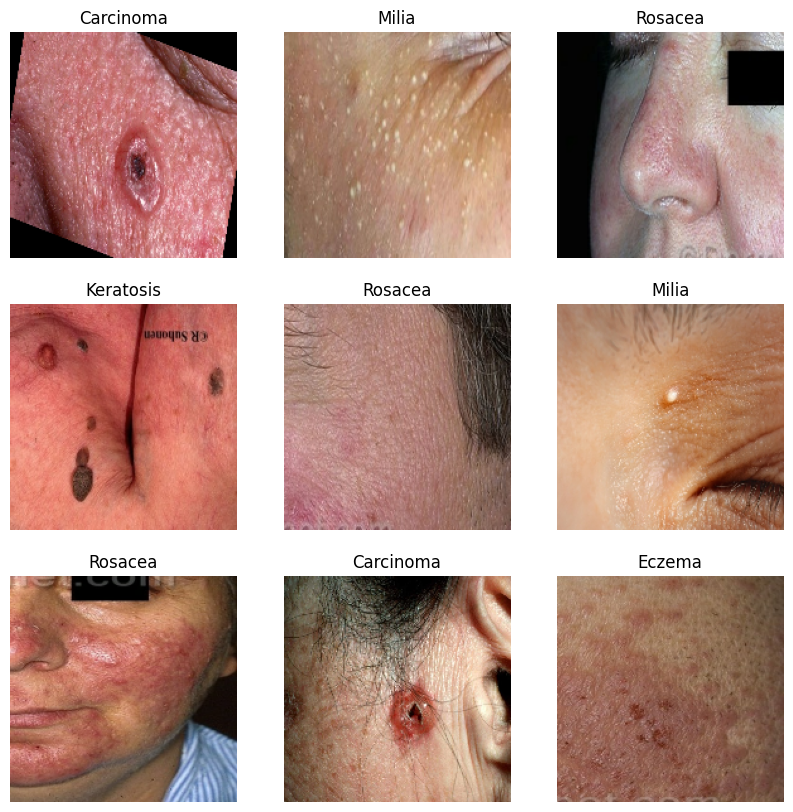

In [99]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_class_names[labels[i]])
    plt.axis("off")

2025-11-16 21:53:36.474760: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


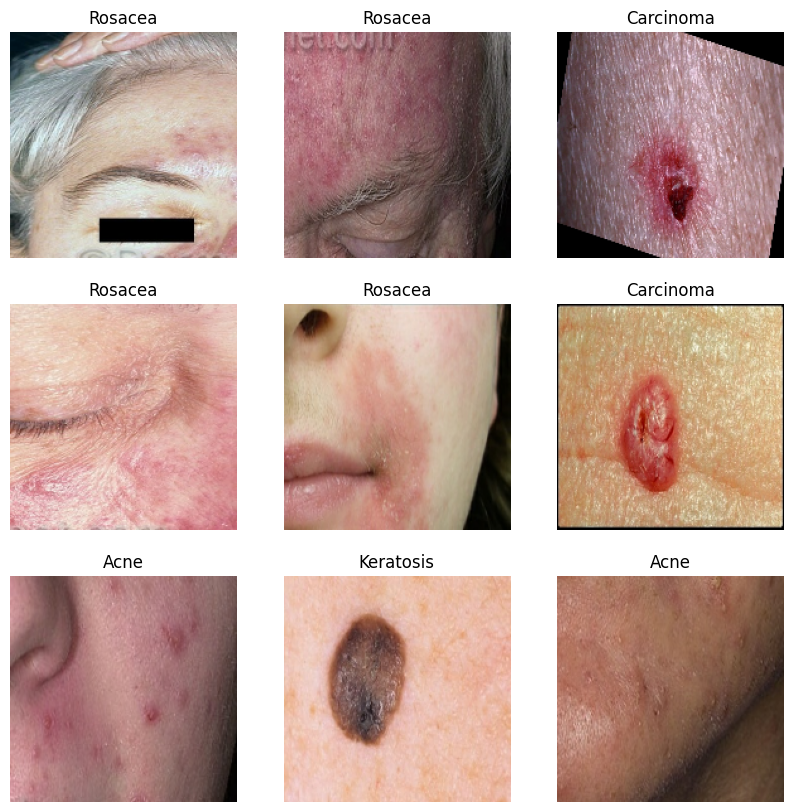

In [100]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(val_class_names[labels[i]])
    plt.axis("off")

the below code shows what the shape of the tensor is. this is a batch of 32 images in the shape `180x180x3` where the last dimension refers to color channels RGB. 

the `label_batch` is a tensor with the shape in the 2nd line, corresponding to labels of the 32 images. 

In [101]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


### standardize data 

this is where we standardize the data. RGB channel values are in the `[0,255]` range, which isn't ideal for a neural network because we want to make our input values small. to standardize our values to be in `[0,1]` range, we're using `tf.kera.layers.Rescaling` and also note this is where the `(1./255)` comes from.

In [102]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

there are 2 ways to use this layer. the first is to apply it to the dataset by calling `Dataset.map` which is what we did below. 

**note:** need to research if it's normal for it to be exactly 1.0 because the tutorial example was 0.96

In [103]:
# apply the normalization to the dataset of images while keeping labels unchanged
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

# creates an iterator over the normalized dataset
image_batch, labels_batch = next(iter(normalized_ds))

# select first image from that batch 
first_image = image_batch[0]

# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.7613072


the 2nd way to use the layer is to include it inside our model definition to simplify deployment. 

### configure dataset for performance

tutorial says to make sure to "use buffered prefetching so you can yield data from disk without having I/O become blocking". what does this mean? 
* when you train a NN, the model runs computations AND the data pipeline is loading images, coding, and preparing them. so if data loading is too slow, the model waits for the next batch, wasting time 
* I/O = input/output, like reading files from my disk 
* blocking = the training process has to wait for the next batch to be ready
* buffered prefethcing loads the next batch WHILE the current one is still being processed, speeding up the process

2 methods to use when fetching data: 
* `Dataset.cache` = keep image in memory after they're loaded off disk during first epoch, ensuring dataset doesn't become a bottleneck when training model 
* `Dataset.prefetch` = overlap data preprocessing and mdoel execution while training

so the below code uses prefetch to have that overlap. 

autotune lets tf dynamically tune the best performance settings for my data pipeline.

In [104]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### train a model

* https://www.tensorflow.org/guide/keras/sequential_model 
* sequential model is appropriate for a plain stack of layers where each layer has exactly 1 input 1 output --> this might not be what we want
* the below code shows the model with convolution blocks, max pooling layer, and a fully connected layer on top of it that is activated by a ReLU activation function
* however, this model hasn't been tuned in any way 

In [106]:
num_classes = 6

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 656ms/step - accuracy: 0.2416 - loss: 1.8063 - val_accuracy: 0.2824 - val_loss: 1.6169
Epoch 2/3
60/60 ━━━━━━━━━━━━━━━━━━━━ 37s 612ms/step - accuracy: 0.4139 - loss: 1.4786 - val_accuracy: 0.5146 - val_loss: 1.2507
Epoch 3/3
60/60 ━━━━━━━━━━━━━━━━━━━━ 38s 638ms/step - accuracy: 0.5491 - loss: 1.2254 - val_accuracy: 0.5816 - val_loss: 1.1256


### IGNORE MUCH OF ABOVE 
### image classification tutorial https://www.tensorflow.org/tutorials/images/classification 

* post dataset configuration and standardization, we can create a basic Keras model

In [ ]:
num_classes = len(train_class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/preprocessing/data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Compile the model next. 

We choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model summary 

View all layers of network using Kera `Model.summary` method. 

**research:** how do i actually make sense of this data though? 

In [ ]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_8 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,414 (15.22 MB)

 Trainable params: 3,989,414 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### train the model

train the model for 10 epochs with the Keras `Model.fit` method

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 326ms/step - accuracy: 0.3439 - loss: 1.6636 - val_accuracy: 0.4854 - val_loss: 1.3378
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 342ms/step - accuracy: 0.5162 - loss: 1.2709 - val_accuracy: 0.5063 - val_loss: 1.2241
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 355ms/step - accuracy: 0.5877 - loss: 1.0811 - val_accuracy: 0.5607 - val_loss: 1.1146
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 332ms/step - accuracy: 0.6430 - loss: 0.9379 - val_accuracy: 0.5983 - val_loss: 1.0997
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 337ms/step - accuracy: 0.7208 - loss: 0.7700 - val_accuracy: 0.6151 - val_loss: 1.0199
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 354ms/step - accuracy: 0.7406 - loss: 0.6834 - val_accuracy: 0.5983 - val_loss: 1.0613
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 331ms/step - accuracy: 0.7782 - loss: 0.5863 - val_accuracy: 0.5586 - val_loss: 1.3314
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 344ms/step - accuracy: 0.8163 - loss: 0.4742 - val_accu

Visualize training results. 

Create plots of loss and accuracy on training and validation sets. 

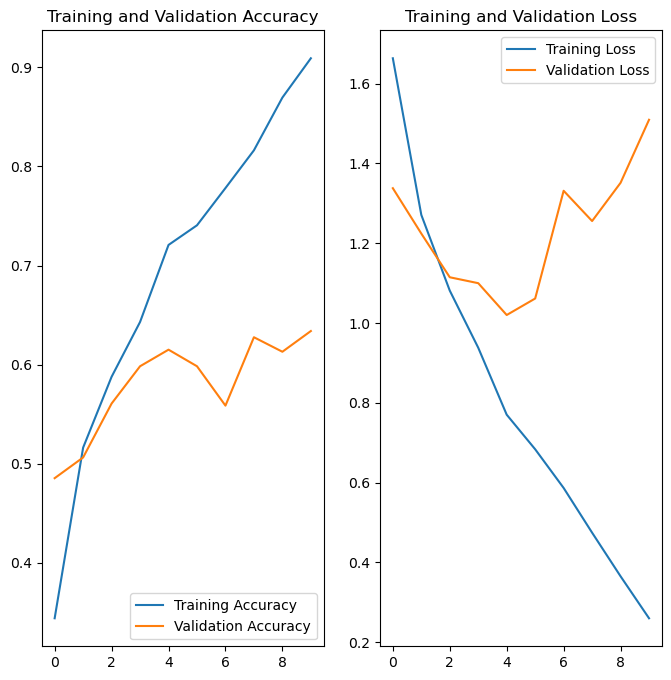

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Overfitting 

We see trainng accuracy increasing linearly over time, but validation accuracy hovers around 60% and doesn't improve. A difference in accuracy b/t training and validation accuracy is a sign of overfitting. 

One method we can use is data augmentation, which generates additional training data from existing samples by augementing them using random transformations that yield believeable looking images. This is in response to the idea that overfitting generally cocurs when there are a small number of training examples. 

In [107]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3), seed = 101),
    layers.RandomRotation(0.1, seed = 101),
    layers.RandomZoom(0.1, seed = 101)
  ]
)

/Users/aidaduong/opt/anaconda3/envs/tf-metal/lib/python3.10/site-packages/keras/src/layers/preprocessing/data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2025-11-16 21:54:56.211908: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-11-16 21:54:56.690093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


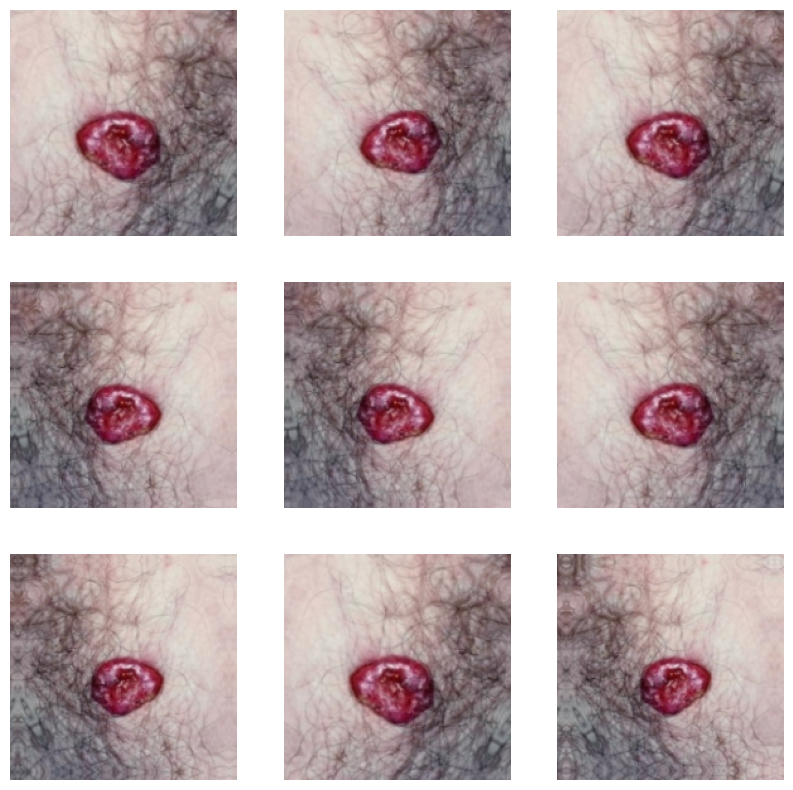

In [108]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Introduce dropout regularization - need to look into this one more 

In [109]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [110]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_9 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_10 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,414 (15.22 MB)

 Trainable params: 3,989,414 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.2129 - loss: 2.0332 - val_accuracy: 0.3096 - val_loss: 1.6845
Epoch 2/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.3330 - loss: 1.5937 - val_accuracy: 0.3787 - val_loss: 1.5447
Epoch 3/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.4796 - loss: 1.3554 - val_accuracy: 0.5063 - val_loss: 1.3688
Epoch 4/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.5428 - loss: 1.2496 - val_accuracy: 0.5335 - val_loss: 1.2646
Epoch 5/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.5527 - loss: 1.2001 - val_accuracy: 0.5669 - val_loss: 1.2434
Epoch 6/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.5705 - loss: 1.1468 - val_accuracy: 0.5502 - val_loss: 1.2699
Epoch 7/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.5783 - loss: 1.1301 - val_accuracy: 0.4603 - val_loss: 1.7228
Epoch 8/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.5548 - loss: 1.2279 - val_accuracy: 0.4519 - v

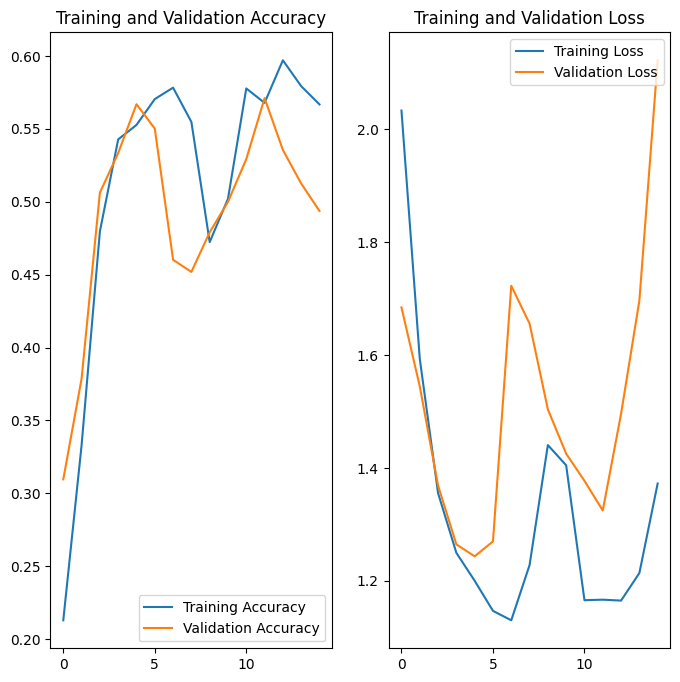

In [111]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

results are better.

### predict on new data

### below is not from tensorflow tutorial

### model evaluation

In [112]:
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Final Validation Loss: {val_loss:.4f}")
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4937 - loss: 2.1223
Final Validation Loss: 2.1223
Final Validation Accuracy: 0.4937


In [113]:
# labeling and predictions
y_true = np.concatenate([y.numpy() for x, y in val_ds], axis=0)
y_pred_logits = np.concatenate([model(x, training=False).numpy() for x, y in val_ds], axis=0)
y_pred = np.argmax(y_pred_logits, axis=1)

# classification report
print(classification_report(y_true, y_pred, target_names=df["labels"].unique()))

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

2025-11-16 21:56:12.124410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


              precision    recall  f1-score   support

        Acne       0.00      0.00      0.00        74
   Carcinoma       0.22      0.88      0.35        84
      Eczema       0.28      0.15      0.20        80
   Keratosis       0.11      0.15      0.13        66
       Milia       0.00      0.00      0.00        87
     Rosacea       0.50      0.01      0.02        87

    accuracy                           0.20       478
   macro avg       0.18      0.20      0.12       478
weighted avg       0.19      0.20      0.12       478

Confusion Matrix:
 [[ 0 57 12  5  0  0]
 [ 0 74  0 10  0  0]
 [ 0 55 12 12  0  1]
 [ 0 54  2 10  0  0]
 [ 0 64  2 21  0  0]
 [ 0 36 15 35  0  1]]


2025-11-16 21:56:12.601189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/Users/aidaduong/opt/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/aidaduong/opt/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/aidaduong/opt/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning